In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing
import itertools
import torch

from core.koopman_core_linear import KoopDNN,KoopmanNet,KoopmanNetCtrl
from models.koop_model import model_matricies,lift
from dynamics.duffing import dynamics_duff
from dynamics.Vanpol import dynamics_vanpol

from core.adapt_net import AdaptNet


In [2]:
# Base Parameters
dt = 0.01 #time step
num_snaps = 500 # no. of snapshots
T = np.linspace(0,num_snaps*dt, num_snaps+1)
num_train = 200 # no. of training examples
num_val = int(0.25*num_train) # no of testing examples
num_traj = num_train+num_val #no of trajectories
num_states = 2 # no. of states
num_inputs = 1 # no. of inputs

In [3]:
# Oscillator parameters
dyn_pars = {}

dyn_pars['a'] = 1
dyn_pars['b'] = 4
dyn_pars['c'] = 0.5
dyn_pars['d'] = 0.5

dyn_pars['del_a'] = 3
dyn_pars['del_b'] = 8
dyn_pars['del_c'] = 5
dyn_pars['del_d'] = 3
dyn_pars['delay'] = False
dyn_pars['delay_time'] = 5
dyn_pars['cont_unc_type'] = 'sinusoidal'

In [4]:
X_changed, X_unchanged, U = dynamics_duff(dt, num_traj, num_snaps, num_states, num_inputs, dyn_pars)

print(X_changed.shape, U.shape)

(250, 501, 2) (250, 500, 1)


In [5]:
l2_diff = np.linalg.norm(X_changed-X_unchanged)/((X_changed.size)**(1/2))
print('l2_diff = ', l2_diff)

l2_diff =  0.26031287783965956


In [6]:
change_in_dym = np.linalg.norm((X_changed-X_unchanged)/X_changed)/X_changed.size
print('fraction of change in dynamics = ', change_in_dym)

fraction of change in dynamics =  16.339385057860955


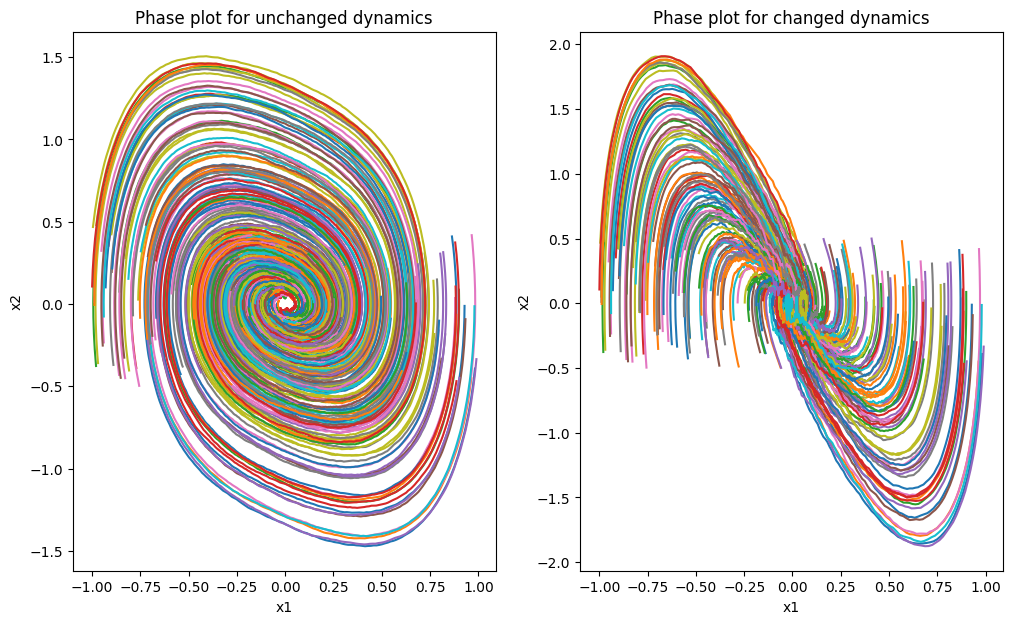

In [7]:
# plot dataset
fig, axs = plt.subplots(1,2,figsize=(12,7))
axs[0].set_title("Phase plot for unchanged dynamics")
axs[1].set_title("Phase plot for changed dynamics")

axs[0].set(xlabel = 'x1', ylabel = 'x2')
axs[1].set(xlabel = 'x1', ylabel = 'x2')

for i in range(num_traj):
    axs[0].plot(X_unchanged[i,:,0], X_unchanged[i,:,1])
    axs[1].plot(X_changed[i,:,0], X_changed[i,:,1])
plt.savefig('phase_plot_duffing.jpg')

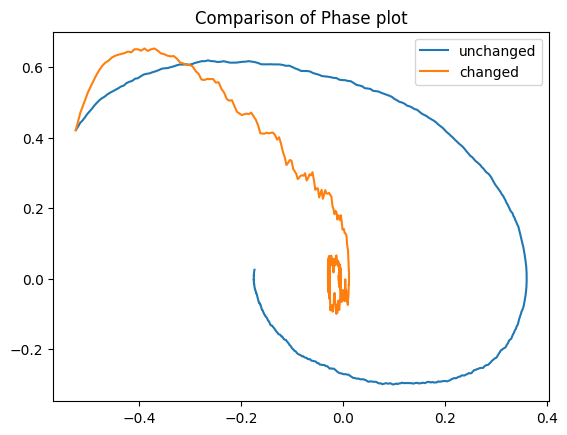

In [8]:
plt.figure()

plt.title('Comparison of Phase plot')
plt.plot(X_unchanged[4,:,0], X_unchanged[4,:,1], label = 'unchanged')
plt.plot(X_changed[4,:,0], X_changed[4,:,1], label = 'changed')

plt.legend()
plt.savefig('phase_plot_duffing_single_traj.jpg')
plt.show()


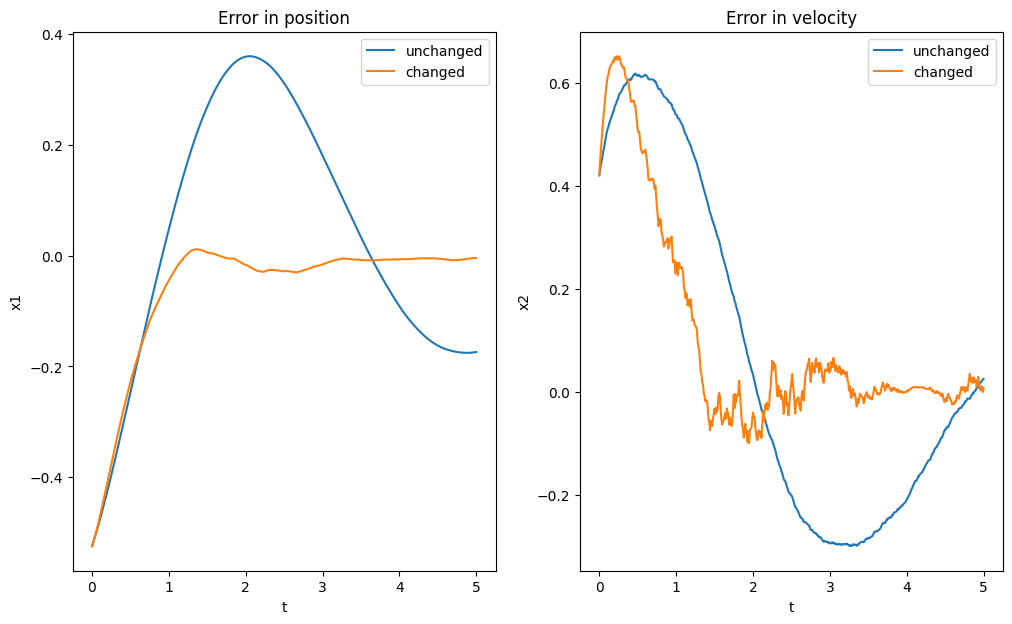

In [9]:
# plot dataset
fig, axs = plt.subplots(1,2,figsize=(12,7))
axs[0].set_title("Error in position")
axs[1].set_title("Error in velocity")

axs[0].set(xlabel = 't', ylabel = 'x1')
axs[1].set(xlabel = 't', ylabel = 'x2')


axs[0].plot(T, X_unchanged[4,:,0], label = 'unchanged')
axs[0].plot(T, X_changed[4,:,0], label = 'changed')
axs[0].legend()

axs[1].plot(T, X_unchanged[4,:,1], label = 'unchanged')
axs[1].plot(T, X_changed[4,:,1], label = 'changed')
axs[1].legend()

plt.savefig('vel_pos_err_duffing_single_traj.jpg')

In [10]:
# split training and vaidation datasets
xs_train, us_train = X_unchanged[:num_train,:,:],U[:num_train,:,:]
xs_val, us_val = X_unchanged[num_train:,:,:],U[num_train:,:,:]

***Koopman bilinear Models***

In [11]:
# auto encoder parameters

net_params = {}
net_params['state_dim'] = num_states
net_params['ctrl_dim'] = num_inputs
net_params['encoder_hidden_width'] = 30
net_params['encoder_hidden_depth'] = 2
net_params['encoder_output_dim'] = 4
net_params['optimizer'] = 'adam'
net_params['activation_type'] = 'tanh'
net_params['lr'] = 2e-4 # 5e-4
net_params['epochs'] = 300
net_params['batch_size'] = 256
net_params['lifted_loss_penalty'] = 0.3
net_params['l2_reg'] = 0.0         
net_params['l1_reg'] = 0.0
net_params['first_obs_const'] = True
net_params['override_C'] = True # this makes the state a part of lifted state
net_params['dt'] = dt

In [12]:
train = False

if train == True:
    file = 'models/learned_models/linear_model/duff_linear_0_01_dim2.pth'
    net = KoopmanNetCtrl(net_params)
    model_koop_dnn = KoopDNN(net)
    model_koop_dnn.set_datasets(xs_train, u_train=us_train, x_val=xs_val, u_val=us_val)
    model_koop_dnn.model_pipeline(net_params)
    model_koop_dnn.construct_koopman_model()
    torch.save(model_koop_dnn,file)
else:
    file = 'models/learned_models/linear_model/duff_linear_0_01_dim2.pth'
    model_koop_dnn = torch.load(file)

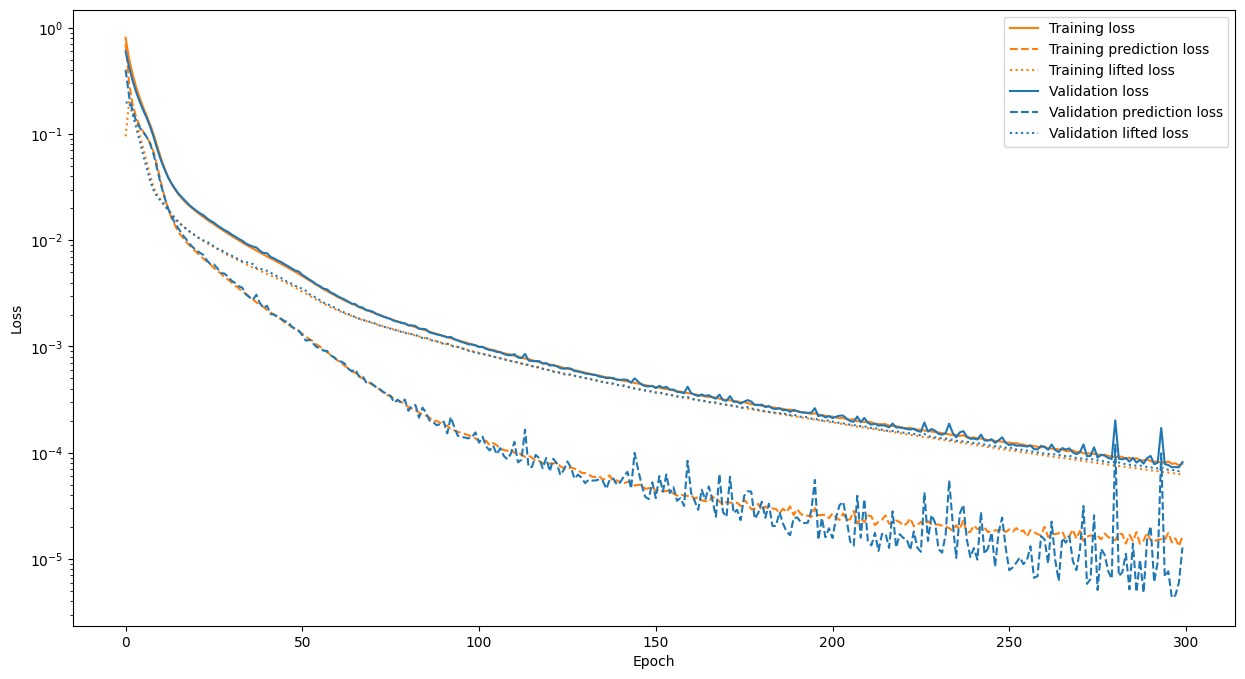

In [13]:
train_loss = [l[0] for l in model_koop_dnn.train_loss_hist]
train_pred_loss = [l[1] for l in model_koop_dnn.train_loss_hist]
train_lifted_loss = [l[2] for l in model_koop_dnn.train_loss_hist]
val_loss = [l[0] for l in model_koop_dnn.val_loss_hist]
val_pred_loss = [l[1] for l in model_koop_dnn.val_loss_hist]
val_lifted_loss = [l[2] for l in model_koop_dnn.val_loss_hist]
epochs = np.arange(0, net_params['epochs'])

plt.figure(figsize=(15,8))
plt.plot(epochs, train_loss, color='tab:orange', label='Training loss')
plt.plot(epochs, train_pred_loss, '--', color='tab:orange', label='Training prediction loss')
plt.plot(epochs, train_lifted_loss, ':', color='tab:orange', label='Training lifted loss')
plt.plot(epochs, val_loss, color='tab:blue', label='Validation loss')
plt.plot(epochs, val_pred_loss, '--', color='tab:blue', label='Validation prediction loss')
plt.plot(epochs, val_lifted_loss, ':', color='tab:blue', label='Validation lifted loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()

# Learned Model Parameters

## Bilinear Model Parameters

In [14]:
A = np.array(model_koop_dnn.A)
#B = np.array(model_koop_dnn.B).reshape(-1,num_inputs*n_obs)
B = np.array(model_koop_dnn.B)
#B_tensor = np.empty((num_inputs,n_obs, n_obs))
#for ii, b in enumerate(B):
    #B_tensor[ii] = b
C = np.array(model_koop_dnn.C)
n_lift = A.shape[0]
print(A.shape, B.shape, C.shape)

(7, 7) (7, 1) (2, 7)


In [15]:
#check controllability
D = np.empty((n_lift,n_lift))
D[:,0] = B.reshape(n_lift)
for r in range(n_lift-1):
    D[:,r+1] = (np.linalg.matrix_power(A,r+1) @ B).reshape(n_lift)

In [16]:
D.shape

(7, 7)

In [17]:
print("rank",np.linalg.matrix_rank(D))

rank 6


In [18]:
import control


In [19]:
np.linalg.matrix_rank(control.ctrb(A,B))

6

In [20]:
#control
from control_files.nmpc_osqp import NonlinearMPCController
from dynamics.learned_models_control.linear_dynamics import linear_Dynamics
import scipy

In [21]:
linear_model = linear_Dynamics(scipy.sparse.csc_matrix(A),scipy.sparse.csc_matrix(B), C)

In [22]:
solver_settings = {}
solver_settings['gen_embedded_ctrl'] = False
solver_settings['warm_start'] = True
solver_settings['polish'] = True
solver_settings['polish_refine_iter'] = 3
solver_settings['scaling'] = True
solver_settings['adaptive_rho'] = False
solver_settings['check_termination'] = 25
solver_settings['max_iter'] = 1000
solver_settings['eps_abs'] = 1e-6
solver_settings['eps_rel'] = 1e-6
solver_settings['eps_prim_inf'] = 1e-4
solver_settings['eps_dual_inf'] = 1e-4
solver_settings['linsys_solver'] = 'qdldl'

In [23]:
#Closed loop performance evaluation parameters:
traj_length = 2000
max_iter = 100
N = 1 #length of horizon
t_eval = dt * np.arange(traj_length+1)                       # Simulation time points, closed loop
Q_mpc = scipy.sparse.diags([100,100])                       # State penalty matrix, trajectory generation
QN_mpc = scipy.sparse.diags([1e3,1e3])         # Final state penalty matrix, trajectory generation
R_mpc = 1*scipy.sparse.eye(num_inputs)                                     # Actuation penalty matrix, trajectory generation
R0_mpc = scipy.sparse.csc_matrix(np.zeros(num_inputs))

# Design trajectory:
x0 = np.array([-0.2, 0.1])                   # Initial value, closed loop trajectory
set_pt = np.array([0, 0])              # Desired final value, closed loop trajectory
x_ref = np.tile(set_pt.reshape(-1,1), (1, traj_length))
xmax = np.array([5, 5])                          # State constraints, trajectory generation
xmin = -xmax
umax = 10
umin = -umax

# Define initial solution for SQP algorithm:
x_init = np.linspace(x0, x0, N+1)
u_init = 1*np.ones((num_inputs, N)).T

In [24]:
z_init = np.empty((N+1,n_lift))
z0 = lift(x0, model_koop_dnn, net_params)
for i in range(N+1):
    z_init[i,:] = lift(x_init[i,:], model_koop_dnn, net_params)


In [25]:
controller_nmpc = NonlinearMPCController(linear_model, N, dt, umin, umax, xmin, xmax, Q_mpc, R_mpc, QN_mpc, solver_settings)
controller_nmpc.construct_controller(z_init, u_init,x_ref[:,0])

(14, 15) (1, 15) (4, 15)


In [26]:
print(controller_nmpc._osqp_A.shape)

(19, 15)


In [27]:
controller_nmpc.trajectory_tracking(x0, z0, x_ref.T, max_iter)

time_step 0
time_step 1
time_step 2
time_step 3
time_step 4
time_step 5
time_step 6
time_step 7
time_step 8
time_step 9
time_step 10
time_step 11
time_step 12
time_step 13
time_step 14
time_step 15
time_step 16
time_step 17
time_step 18
time_step 19
time_step 20
time_step 21
time_step 22
time_step 23
time_step 24
time_step 25
time_step 26
time_step 27
time_step 28
time_step 29
time_step 30
time_step 31
time_step 32
time_step 33
time_step 34
time_step 35
time_step 36
time_step 37
time_step 38
time_step 39
time_step 40
time_step 41
time_step 42
time_step 43
time_step 44
time_step 45
time_step 46
time_step 47
time_step 48
time_step 49
time_step 50
time_step 51
time_step 52
time_step 53
time_step 54
time_step 55
time_step 56
time_step 57
time_step 58
time_step 59
time_step 60
time_step 61
time_step 62
time_step 63
time_step 64
time_step 65
time_step 66
time_step 67
time_step 68
time_step 69
time_step 70
time_step 71
time_step 72
time_step 73
time_step 74
time_step 75
time_step 76
time_step

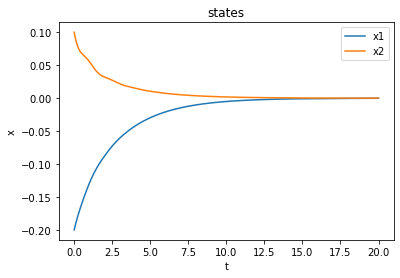

In [114]:
plt.figure()
plt.plot(t_eval, controller_nmpc.x_traced[:,0],label ='x1')
plt.plot(t_eval, controller_nmpc.x_traced[:,1],label = 'x2')
plt.xlabel('t')
plt.ylabel('x')
plt.title('states')
plt.legend()
plt.show()

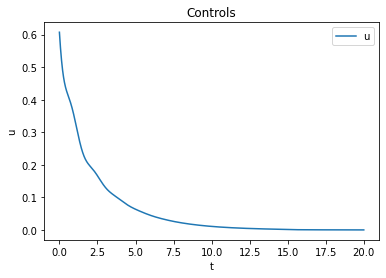

In [115]:
plt.figure()
plt.plot(t_eval[:-1], controller_nmpc.controls,label ='u')
plt.xlabel('t')
plt.ylabel('u')
plt.title('Controls')
plt.legend()
plt.show()

## Lifting function

# Testing

## Parameters

In [81]:
# test data parameters
num_snaps_test = 2000 # no. of snapshots
T_test = np.linspace(0,num_snaps_test*dt, num_snaps_test+1)
num_traj_test = 1 # no. of training examples
first_obs_const = int(net_params['first_obs_const']) #only one state
override_C = net_params['override_C']
if override_C:
    n_obs = int(net_params['encoder_output_dim']) + num_states + first_obs_const 
else:
    n_obs = int(net_params['encoder_output_dim']) + first_obs_const 

## Testing Data

In [82]:
x_changed_test, x_unchanged_test, u_test = dynamics_duff(dt, num_traj_test, num_snaps_test,num_states, num_inputs, dyn_pars)
print(model_koop_dnn.test_loss(x_unchanged_test,u_test = u_test))

tensor(2.0155e-05)


In [83]:
x_unchanged_test.shape

(1, 2001, 2)

In [84]:
# Use the preprocessing if available
X_unchanged,_ = model_koop_dnn.net.process(x_unchanged_test,data_u = u_test)
X_changed,_ = model_koop_dnn.net.process(x_changed_test,data_u = u_test)

In [85]:
X_changed.shape

(2000, 5)

In [86]:
# flatten vector
x_unchanged = X_unchanged[:, :num_states]
u = X_unchanged[:, num_states:num_states+num_inputs]
x_unchanged_prime = X_unchanged[:,num_states+num_inputs:]

x_changed = X_changed[:, :num_states]
x_changed_prime = X_changed[:,num_states+num_inputs:]

x_changed_dot = (x_changed_prime-x_changed)/dt
print(x_changed.shape, u.shape, x_changed_prime.shape)

(2000, 2) (2000, 1) (2000, 2)


# Lifting of states

In [87]:
# initialize states
# initialize the matricies
z_unchanged = np.empty((n_obs,num_snaps_test+1)).T   #lifted state
x_unchanged_est = np.zeros((num_states,num_snaps_test+1)).T #estimated values

In [88]:
# actual lift
z_unchanged[0,:] = lift(x_unchanged[0,:],model_koop_dnn, net_params)
x_unchanged_est[0,:] = x_unchanged[0,:]

ValueError: could not broadcast input array from shape (6,) into shape (4,)

# Time Evolution

In [ ]:
for i in range(num_snaps_test):
  #bilinear
    z_unchanged[i+1,:] = np.matmul(z_unchanged[i,:],A.T)+np.matmul(u[i,:],B.T)
    x_unchanged_est[i+1,:] = np.matmul(z_unchanged[i+1,:],C.T)

# Plotting

## Lifting performance

In [ ]:
plt.figure()
plt.plot(T_test[:-1], x_unchanged[:,0],label ='Test unchanged data')
plt.plot(T_test, x_unchanged_est[:,0],label = 'estimated unchanged dyn (bilinear)')
plt.xlabel('t')
plt.ylabel('x1')
plt.title('Position Comparison')
plt.legend()
plt.show()

In [ ]:
plt.figure()
plt.plot(T_test[:-1],x_unchanged[:,1],label ='Test data')
plt.plot(T_test,x_unchanged_est[:,1],label = 'esimated unchanged dyn (bilinear)')
plt.xlabel('t')
plt.ylabel('x2')
plt.title('Velocity Comparison')
plt.legend()
plt.show()

In [ ]:
plt.figure()
plt.plot(x_unchanged[:,0],x_unchanged[:,1],label ='Test data')
plt.plot(x_unchanged_est[:,0],x_unchanged_est[:,1],label = 'esimated unchanged dyn (bilinear)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Phase Space trajectory Comparison')
plt.legend()
plt.show()

### Error Evolution

In [ ]:
error_model = np.linalg.norm((x_unchanged_est[:-1,:]-x_unchanged[:,:]),axis=1)
error_dynamics_no_adapt = np.linalg.norm((x_changed[:,:]-x_unchanged[:,:]),axis=1)

In [ ]:
plt.figure()
plt.plot(T_test[:-1],error_model)
plt.xlabel('t')
plt.ylabel('e')
plt.title('Model error evolution')
plt.show()

## Deviation from Actual Dynamics

In [ ]:
plt.figure()
plt.plot(T_test[:-1],x_changed[:,0],label ='Test data (changed dynamics)')
plt.plot(T_test[:-1],x_unchanged[:,0],label ='Test data (unchanged dynamics)')
plt.plot(T_test,x_unchanged_est[:,0],label = 'esimated unchanged dyn (bilinear)')
plt.xlabel('t')
plt.ylabel('x1')
plt.title('Position Comparison')
plt.legend()
plt.show()

In [ ]:
plt.figure()
plt.plot(T_test[:-1],x_changed[:,1],label ='Test data (changed model)')
plt.plot(T_test[:-1],x_unchanged[:,1],label ='Test data (unchanged model)')
plt.plot(T_test,x_unchanged_est[:,1],label = 'esimated unchanged dyn (bilinear)')
plt.xlabel('t')
plt.ylabel('x1')
plt.title('Velocity Comparison')
plt.legend()
plt.show()

In [ ]:
plt.figure()
plt.plot(x_changed[:,0],x_changed[:,1],label ='Test data (changed dyn)')
plt.plot(x_unchanged[:,0],x_unchanged[:,1],label ='Test data (unchanged dyn)')
plt.plot(x_unchanged_est[:,0],x_unchanged_est[:,1],label = 'esimated unchanged dyn (bilinear)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Phase Space trajectory Comparison')
plt.legend()
plt.show()

In [ ]:
plt.figure()
plt.plot(T_test[:-1],error_dynamics_no_adapt)
plt.xlabel('t')
plt.ylabel('e')
plt.title('Dynamics error evolution')
plt.show()

# Adaptation

## Data Preprocessing

In [ ]:
# initialize state matricies
z_adap = np.empty((n_obs,num_snaps_test+1)).T   #lifted state
z_changed = np.empty((n_obs,num_snaps_test)).T #actual lifted state
del_z_prime = np.empty((n_obs,num_snaps_test)).T
zu_unchanged = np.empty((n_obs*num_inputs,num_snaps_test)).T
x_adap_est = np.zeros((num_states,num_snaps_test+1)).T #estimated values
del_A_norm = np.zeros((num_snaps_test,1))
del_B_norm = np.zeros((num_snaps_test,1))
# initialize
z_adap[0,:] = z_unchanged[0,:]
zu_unchanged[0,:] = np.kron(u[0,:],z_unchanged[0,:])
x_adap_est[0,:] = x_unchanged[0,:]

#
adap_window = 1 #hyperparameter

# Adaptive Time evolution

In [ ]:
adapt_net_params = {}
adapt_net_params['state_dim'] = num_states
adapt_net_params['ctrl_dim'] = num_inputs
adapt_net_params['lift_dim'] = 20
adapt_net_params['optimizer'] = 'adam'
adapt_net_params['lr'] = 5e-4 # 5e-4
adapt_net_params['epochs'] = 8
adapt_net_params['batch_size'] = adap_window
adapt_net_params['l2_reg'] = 0.0
adapt_net_params['l1_reg'] = 1e-3
adapt_net_params['first_obs_const'] = net_params["first_obs_const"]
adapt_net_params['override_C'] = net_params["override_C"] # this makes the state a part of lifted state

del_A = np.zeros_like(A)
del_B = np.zeros_like(B)
for i in range(num_snaps_test):
  # incorrect dynamics
    zu_unchanged[i,:] = np.kron(u[i,:],z_adap[i,:])
    z_unchanged[i+1,:] = np.matmul(z_adap[i,:],A.T + del_A.T)+np.matmul(zu_unchanged[i,:],B.T + del_B.T)
    # z_unchanged[i+1,:] = np.matmul(z_adap[i,:],A.T)+np.matmul(zu_unchanged[i,:],B.T)
    
    z_changed[i,:] = lift(x_changed[i,:],model_koop_dnn, net_params)
    
    del_z_prime[i,:] = z_changed[i,:] - z_unchanged[i,:]
    if i < adap_window + 1 :
        del_A = np.zeros_like(A)
        del_B = np.zeros_like(B)
    else:
        del_Z_prime = del_z_prime[i-adap_window:i,:].T
        Z_unchanged = z_unchanged[i-(adap_window+1):i-1].T
        ZU_unchanged = zu_unchanged[i-(adap_window+1):i-1].T

        #invoke neural net for adapation
        adapt_network = AdaptNet(adapt_net_params)
        adapt_network.model_pipeline(Z_unchanged, ZU_unchanged, del_Z_prime, print_epoch = True)

        del_A, del_B = adapt_network.get_del_matrices()

    del_A_norm[i] = np.linalg.norm(del_A)
    del_B_norm[i] = np.linalg.norm(del_B)
    
    # adapted model
    z_adap[i+1,:] = np.matmul(z_adap[i,:], A.T+del_A.T) + np.matmul(np.kron(u[i,:],z_adap[i,:]), B + del_B.T )
    x_adap_est[i+1,:] = np.matmul(z_adap[i+1,:],C.T)

In [ ]:
A.T.shape, del_A.shape

# Performance Plotting

In [ ]:
plt.figure()
plt.plot(T_test[:-1],x_changed[:,0],label ='Test data from changed dynamics')
plt.plot(T_test[:],x_unchanged_est[:,0],label ='estimated (no adapt)')
plt.plot(T_test,x_adap_est[:,0],label = 'esimated (adapt)')
plt.xlabel('t')
plt.ylabel('x1')
plt.title('Position Comparison')
plt.legend()
plt.savefig('adap_pos.pdf')

In [ ]:
plt.figure()
plt.plot(T_test[:-1],x_changed[:,1],label ='Test data from changed dynamics')
plt.plot(T_test[:],x_unchanged_est[:,1],label ='estimated (no adapt)')
plt.plot(T_test,x_adap_est[:,1],label = 'esimated (adapt)')
plt.xlabel('t')
plt.ylabel('x2')
plt.title('Velocity Comparison')
plt.legend()
plt.savefig('adap_vel.pdf')

In [ ]:
plt.figure()
plt.plot(x_changed[:,0],x_changed[:,1],label ='Test data from changed dynamics')
plt.plot(x_unchanged_est[:,0],x_unchanged_est[:,1],label ='estimated (no adapt)')
plt.plot(x_adap_est[:,0],x_adap_est[:,1],label = 'estimated (adapt)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Position Comparison')
plt.legend()
plt.savefig('adap_phase.pdf')

# Error Comparisons

In [ ]:
error_dynamics_adap = np.linalg.norm((x_adap_est[:-1,:]-x_changed[:,:]), axis=1)

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(12,7))
axs[0].set_title("Error in Adaptive Model")
axs[1].set_title("Error in Non-Adaptive Model")

axs[0].set(xlabel = 't', ylabel = 'error')
axs[1].set(xlabel = 't', ylabel = 'error')


axs[0].plot(T_test[:-1],error_dynamics_adap)

axs[1].plot(T_test[:-1],error_dynamics_no_adapt)

plt.savefig('adap_error_comp.pdf')

## Norm evolutions

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(12,7))
axs[0].set_title(" ||del_A|| Evolution")
axs[1].set_title("||del_B|| Evolution")

axs[0].set(xlabel = 't', ylabel = '||del_A||')
axs[1].set(xlabel = 't', ylabel = '||del_B||')


axs[0].plot(T_test[:-1],del_A_norm)

axs[1].plot(T_test[:-1],del_B_norm)
plt.show()

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(12,7))
axs[0].set_title(" ||del_A|| Evolution")
axs[1].set_title("||del_B|| Evolution")

axs[0].set(xlabel = 't', ylabel = '||del_A||')
axs[1].set(xlabel = 't', ylabel = '||del_B||')


axs[0].plot(T_test[:-1],del_A_norm)

axs[1].plot(T_test[:-1],del_B_norm)
plt.show()

In [ ]:
np.linalg.norm(A)